In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, dblquad
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

import warnings
warnings.filterwarnings('ignore')

In [2]:
def finite_volumes(N, show_matrix=False, save_plot=False):
    dx, dy = 1, 10
    u = lambda x, y: np.sin(np.pi*x)*np.cos(np.pi*y)
    f = lambda x, y: (dx+dy)*np.pi**2*u(x, y)
    h = 1/N
    A = np.zeros((N*N, N*N))
    b = np.zeros((N*N))

    for j in range(0, N):
        for i in range(0, N):
            row = i*N+j
            b[row] = h**2 * f((i+0.5)*h, (j+0.5)*h) #dblquad(f, j*h, (j+1)*h, lambda x: i*h, lambda x: (i+1)*h)[0]

            u_left = 0
            u_bottom = np.sin(np.pi*(i+0.5)*h) #1/h*quad(lambda x: np.sin(np.pi*x), i*h, (i+1)*h)[0]
            q_right = h*np.pi*np.cos(np.pi*(j+0.5)*h) #quad(lambda y: np.pi*np.cos(np.pi*y), j*h, (j+1)*h)[0]
            q_top = 0

            if i == 0 and j == 0:   #left Dirichlet & bottom Dirichlet
                A[row][(i+1)+j*N] = -dx
                A[row][i+j*N] = 3*dx + 3*dy
                A[row][i+(j+1)*N] = -dy
                b[row] += 2*dx*u_left + 2*dy*u_bottom

            elif i == 0 and j == N-1: #left Dirichlet & top Neumann
                A[row][(i+1)+j*N] = -dx
                A[row][i+j*N] = 3*dx + dy
                A[row][i+(j-1)*N] = -dy
                b[row] += 2*dx*u_left - q_top

            elif i == N-1 and j == N-1: #right Neumann & top Neumann
                A[row][(i-1)+j*N] = -dx
                A[row][i+j*N] = dx + dy
                A[row][i+(j-1)*N] = -dy
                b[row] -= q_right + q_top

            elif i == N-1 and j == 0: #right Neumann & bottom Dirichlet
                A[row][(i-1)+j*N] = -dx
                A[row][i+j*N] = dx + 3*dy
                A[row][i+(j+1)*N] = -dy
                b[row] += -q_right + 2*dy*u_bottom

            elif i == 0:            #left Dirichlet
                A[row][(i+1)+j*N] = -dx
                A[row][i+j*N] = 3*dx + 2*dy
                A[row][i+(j-1)*N] = -dy
                A[row][i+(j+1)*N] = -dy
                b[row] += 2*dx*u_left

            elif j == 0:            #bottom Dirichlet
                A[row][(i-1)+j*N] = -dx
                A[row][(i+1)+j*N] = -dx
                A[row][i+j*N] = 2*dx + 3*dy
                A[row][i+(j+1)*N] = -dy
                b[row] += 2*dy*u_bottom

            elif i == N-1:            #right Neumann
                A[row][(i-1)+j*N] = -dx
                A[row][i+j*N] = dx + 2*dy
                A[row][i+(j-1)*N] = -dy
                A[row][i+(j+1)*N] = -dy
                b[row] -= q_right

            elif j == N-1:            #top Neumann
                A[row][(i-1)+j*N] = -dx
                A[row][(i+1)+j*N] = -dx
                A[row][i+j*N] = 2*dx + dy
                A[row][i+(j-1)*N] = -dy
                b[row] -= q_top

            else:                   #inner element
                A[row][(i-1)+j*N] = -dx
                A[row][(i+1)+j*N] = -dx
                A[row][i+j*N] = 2*dx + 2*dy
                A[row][i+(j-1)*N] = -dy
                A[row][i+(j+1)*N] = -dy

    solution = spsolve(A, b)

    _, ax = plt.subplots(1, 3, figsize=(12, 4))
    x = y = np.arange(0+h/2, 1, h)
    xx, yy = np.meshgrid(x, y)
    ax[0].contourf(x, y, u(xx, yy), levels=15)
    #ax[0].clabel(CS, inline=True, fontsize=10)
    ax[0].set_title(r'Contours of $u(x,y)=\sin(\pi x)\cos(\pi y)$')
    ax[1].imshow(u(xx, yy), origin='lower')
    ax[1].set_title(r'Discretization of $u(x,y)$')
    ax[2].imshow(solution.reshape(N, N), origin='lower')
    ax[2].set_title('Approximate solution')
    plt.tight_layout()
    if save_plot:
        plt.savefig('plot.pdf')
    plt.show()

    L_err = 0
    u_true = np.zeros((N*N))
    for i in range(N):
        for j in range(N):
            u_true[i+N*j] = 1/h**2 * dblquad(u, j*h, (j+1)*h, lambda x: i*h, lambda x: (i+1)*h)[0]
            diff_vol = lambda x, y: (solution[i + N*j] - u_true[i+N*j]) ** 2
            L_err += dblquad(diff_vol, j*h, (j+1)*h, i*h, (i+1)*h)[0]
    C_err = np.abs(solution - u_true).max()
    L_err = np.sqrt(L_err)

    print(f"C-norm residual: {C_err:.6f} \nL2-norm residual: {L_err:.6f}")

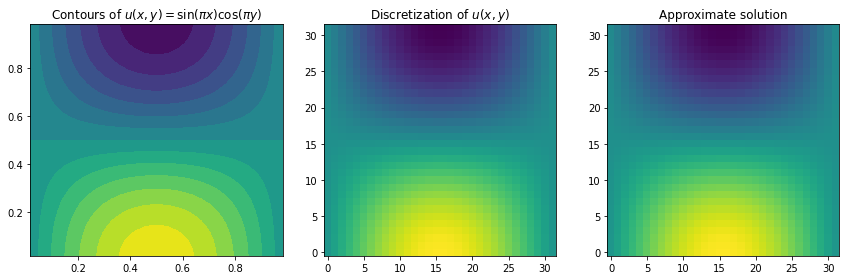

C-norm residual: 0.002000 
L2-norm residual: 0.000859


In [3]:
finite_volumes(32, save_plot=True)

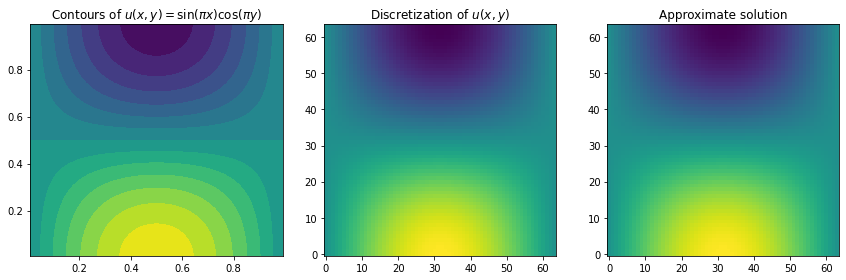

C-norm residual: 0.000501 
L2-norm residual: 0.000215


In [4]:
finite_volumes(64)

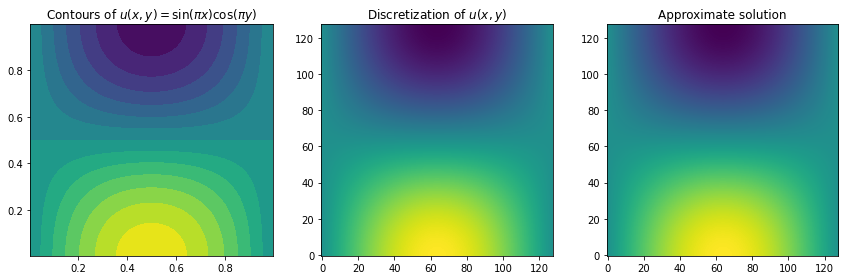

C-norm residual: 0.000125 
L2-norm residual: 0.000054


In [5]:
finite_volumes(128)